In [1]:
%load_ext autoreload
%autoreload 2
# provide cell timings
%load_ext autotime
from qdef import *
%config Completer.use_jedi = False
%config InlineBackend.figure_format = 'retina'
import sympy as sp
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
from matrixgoodies import *
from uncertainties import ufloat
from misc import *
plot_style = 'default'
plt.style.use(plot_style)
import copy
from collections import Counter
import sys

Reloading /Users/juan/ZiaLab/Codebase/qdef/data/CPGs.pkl ...


In [2]:
from crystal_secrets import *

In [3]:
from matminer.data_retrieval.retrieve_MP import MPDataRetrieval
from crystal_secrets import *
mpdr = MPDataRetrieval(api_key=secrets['materials_project_api_key'])

In [4]:
# from crystalcalcs import *

In [5]:
yalo = mpdr.get_data('mp-3792', properties = ['structure'])[0]['structure']

In [6]:
from pymatgen.symmetry.analyzer import PointGroupAnalyzer

In [107]:
def calculate_vacancy_complexes(structure, dopant, tol=0.001):
    '''This function takes the structure of a unit cell and computes the
    possible vacancy complexes and their point group symmetry.

    Parameters:
    structure (pymatgen.core.structure.Structure): unit cell of the crystal
    dopant    (str): element symbol for the substitutional atom
    tol     (float): tolerance distance for the inclusion of nearest neighbors

    Returns:
    list: a list of lists where the first element is a string equal to the
          corresponding point group, and the second element equals a
          pymatgen.core.structure.Molecule molecule

    '''

    # compute the coordinates and species of all the atoms in the unit cell
    coords = np.array([[atom.x, atom.y, atom.z] for atom in structure.sites])
    species = [atom.name for atom in structure.species]
    # initialize a list where defect structures will be saved
    defects = []
    num_sites = len(species)
    structure_vol = structure.volume
    structure_r = structure_vol**(1/3)
    # - iterate through each of the unit cell atoms
    # - replace each by the given dopant
    # - find atoms within a sphere with volume equal to the unit cell vol
    # - find the nearest neighbors
    # - replace each of them by a vacancy, one at a time,
    # - determine what point group symmetry results
    for i in range(num_sites):
        dopant_coord = coords[i]
        this_defect = structure.get_sites_in_sphere(dopant_coord, structure_r)
        this_species = [atom[0].specie.name for atom in this_defect]
        this_coords = np.array([atom[0].coords for atom in this_defect])
        # index might be different, find the new one
        new_index = np.arange(len(this_coords))[np.all(this_coords == dopant_coord, axis=1)][0]
        # change the atom to the given dopant
        this_species[new_index] = dopant
        # find distances to other atoms
        distances = np.array([np.linalg.norm(dopant_coord - coord) for coord in this_coords])
        # find the nearest neighbors
        minDistance = distances[np.argsort(distances)[1]]
        neighbors = np.arange(len(this_coords))[np.abs(distances-minDistance) < tol]
        # replace each of them by a vacancy, one at a time
        for neighbor in neighbors:
            replacing = this_species[neighbor]
            this_species[neighbor] = 'V'
            a_defect = mg.core.structure.Molecule(this_species, this_coords)
            finder = PointGroupAnalyzer(a_defect)
            pg = str(finder.get_pointgroup())
            defects.append([pg, a_defect])
            # put the original atom back in the list of species
            this_species[neighbor] = replacing
    return defects

In [108]:
from pymatgen.symmetry import site_symmetries

In [222]:
def calculate_site_syms(structure, dopant, dtol=0.1, ptol=0.1):
    '''This function takes the structure of a unit cell and computes the
    possible site symmetries for substitutional atoms.

    Parameters:
    structure (pymatgen.core.structure.Structure): unit cell of the crystal
    dopant    (str): element symbol for the substitutional atom
    tol     (float): tolerance distance for the inclusion of nearest neighbors

    Returns:
    list: a list of lists where the first element is a string equal to the
          corresponding point group, and the second element equals a
          pymatgen.core.structure.Molecule molecule

    '''

    # compute the coordinates and species of all the atoms in the unit cell
    coords = np.array([[atom.x, atom.y, atom.z] for atom in structure.sites])
    species = [atom.name for atom in structure.species]
    # initialize a list where defect structures will be saved
    defects = []
    num_sites = len(species)
    structure_vol = structure.volume
    structure_r = structure_vol**(1/3)
    # - iterate through each of the unit cell atoms
    # - replace each by the given dopant
    # - find atoms within a sphere with volume equal to the unit cell vol
    # - determine what point group symmetry results when substituting
    # - each atom with a dopant atom
    for i in range(num_sites):
        dopant_coord = coords[i]
        this_defect = structure.get_sites_in_sphere(dopant_coord, 2*structure_r)
        this_species = [atom[0].specie.name for atom in this_defect]
        this_coords = np.array([atom[0].coords for atom in this_defect])
        # index might be different, find the new one
        new_index = np.arange(len(this_coords))[np.all(this_coords == dopant_coord, axis=1)][0]
        # change the atom to the given dopant
        replacing = this_species[new_index]
        this_species[new_index] = dopant
        # find distances to other atoms
        distances = np.array([np.linalg.norm(dopant_coord - coord) for coord in this_coords])
        # print(distances)
        # find the nearest neighbors
        minDistance = distances[np.argsort(distances)[1]]
        neighbors = np.arange(len(this_coords))[np.abs(distances-minDistance) < dtol]
        picker = np.abs(distances-minDistance) < dtol
        picker[distances == 0] = True
        # print(neighbors)
        # print(this_species)
        # print(this_coords)
        a_defect = mg.core.structure.Molecule(np.array(this_species)[picker], np.array(this_coords)[picker])
        finder = PointGroupAnalyzer(a_defect, tolerance=ptol)
        pg = str(finder.get_pointgroup())
        defects.append([pg, replacing, a_defect])
        if replacing == 'Al':
            break
    return defects
    non_equiv_defects = {}
    for defect in defects:
        key = tuple(defect[:2])
        if key not in non_equiv_defects:
            non_equiv_defects[key] = defect[2]
    return non_equiv_defects

In [223]:
import pymatgen as mg

In [234]:
[calculate_site_syms(yalo,'Cr',2,tol)[-1][0] for tol in np.linspace(0.1,0.9,10)]

['Ci', 'Ci', 'Ci', 'Ci', 'Ci', 'Ci', 'Ci', 'Ci', 'Ci', 'Ci']

In [12]:
from pymatgen.io.cif import CifWriter

In [175]:
CifWriter(sites[('Cs','Al')].get_boxed_structure(a=20,b=20,c=20)).write_file('YAP-Al-site-2.cif')

In [176]:
!open YAP-Al-site-2.cif

In [23]:
yalo_complexes = calculate_vacancy_complexes(yalo, 'Cr')

In [236]:
from pymatgen.io.cif import CifParser

In [ ]:
this_defect = structure.get_sites_in_sphere(dopant_coord, 2*structure_r)

In [547]:
special_site = 'Al'
sphere_radius = 6
crystal = CifParser('/Users/juan/Downloads/Old/2022/Week-11/ICSD_CollCode4115 - YAP.cif')
# crystal = CifParser('/Users/juan/Downloads/Old/2022/Week-11/ICSD_CollCode20090 - YAG.cif')
crystal_structure = crystal.get_structures()[0]
crystal_sites = crystal_structure.get_sites_in_sphere([0,0,0], sphere_radius)
atom_coords = list(map(lambda x: x.coords, crystal_sites))
atom_symbols = list(map(lambda x: x.species.elements[0].element.symbol, crystal_sites))
neighbors = []
for idx, crystal_site in enumerate(crystal_sites):
    at_symbol = crystal_site.species.elements[0].element.symbol
    site_coords = crystal_site.coords
    if at_symbol == special_site:
        neigbbor = crystal_structure.get_neighbors(crystal_site,2.5)
        neigbbor = list(filter(lambda x: x.species.elements[0].element.symbol != special_site, neigbbor))
        neighbors.append({'center': crystal_site, 'neighborhood': neigbbor})

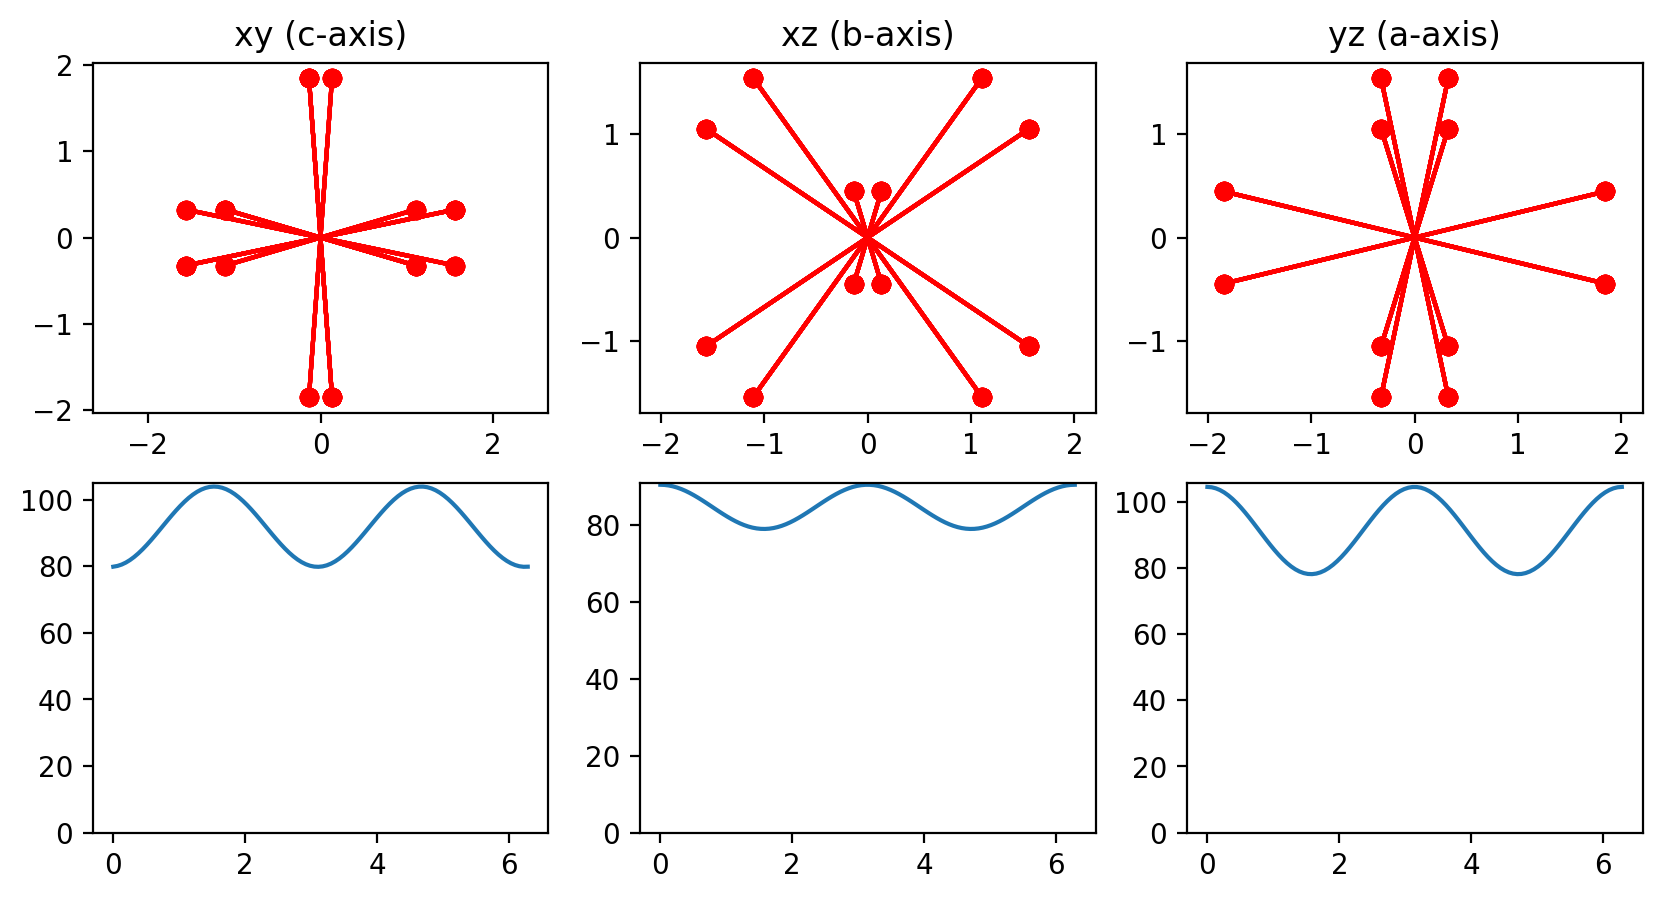

In [555]:
xyphases = []
xzphases = []
yzphases = []
θs = np.linspace(0,2*np.pi,100)
fig, ax = plt.subplots(ncols=3, nrows=2, figsize=(10,5))
for surroundings in neighbors:
    site = surroundings['center']
    neighborhood = surroundings['neighborhood']
    drs = []
    for idx_0 in range(len(surroundings['neighborhood'])):
        for idx_1 in range(idx_0+1,len(surroundings['neighborhood'])):
            r0 = neighborhood[idx_0].coords
            r1 = neighborhood[idx_1].coords
            dr0 = site.coords - r0
            dr0 = np.sqrt(np.sum(dr0**2))
            dr = r0-r1
            r = np.sqrt(np.sum(dr**2))
            if r < 2*1.90:
                continue
            # xyproj = np.array([dr[0],dr[1]])
            # xzproj = np.array([dr[0],dr[2]])
            # yzproj = np.array([dr[1],dr[2]])
            drs.append(dr)
    
    for dr in drs: 
        xyproj = np.array([dr[0],dr[1]])
        xzproj = np.array([dr[0],dr[2]])
        yzproj = np.array([dr[1],dr[2]])
        xyprojθ = np.arctan2(dr[1],dr[0])
        xzprojθ = np.arctan2(dr[2],dr[0])
        yzprojθ = np.arctan2(dr[2],dr[1])
        xyphases.append([np.sqrt(np.sum(xyproj**2)),xyprojθ])
        xzphases.append([np.sqrt(np.sum(xzproj**2)),xzprojθ])
        yzphases.append([np.sqrt(np.sum(yzproj**2)),yzprojθ])
        ax[0][0].plot([-xyproj[0]/2,xyproj[0]/2],[-xyproj[1]/2,xyproj[1]/2],'ro-')
        ax[0][1].plot([-xzproj[0]/2,xzproj[0]/2],[-xzproj[1]/2,xzproj[1]/2],'ro-')
        ax[0][2].plot([-yzproj[0]/2,yzproj[0]/2],[-yzproj[1]/2,yzproj[1]/2],'ro-')
        for axis, axis_name in zip(ax[0],['xy (c-axis)','xz (b-axis)','yz (a-axis)']):
            axis.axis('equal')
            axis.set_title(axis_name)
# xyphases = np.linspace(0,2*np.pi,100)
ax[1][0].plot(θs, np.sum([ amp*np.sin(θs-phase)**2 for amp, phase in xyphases], axis=0))
ax[1][1].plot(θs, np.sum([ amp*np.sin(θs-phase)**2 for amp, phase in xzphases], axis=0))
ax[1][2].plot(θs, np.sum([ amp*np.sin(θs-phase)**2 for amp, phase in yzphases], axis=0))
for axis in ax[1]:
    axis.set_ylim(bottom=0)
plt.show()

In [537]:
np.sum(np.array([np.sin(θs-phase)**2 for phase in xyphases]), axis=0).shape

(100,)

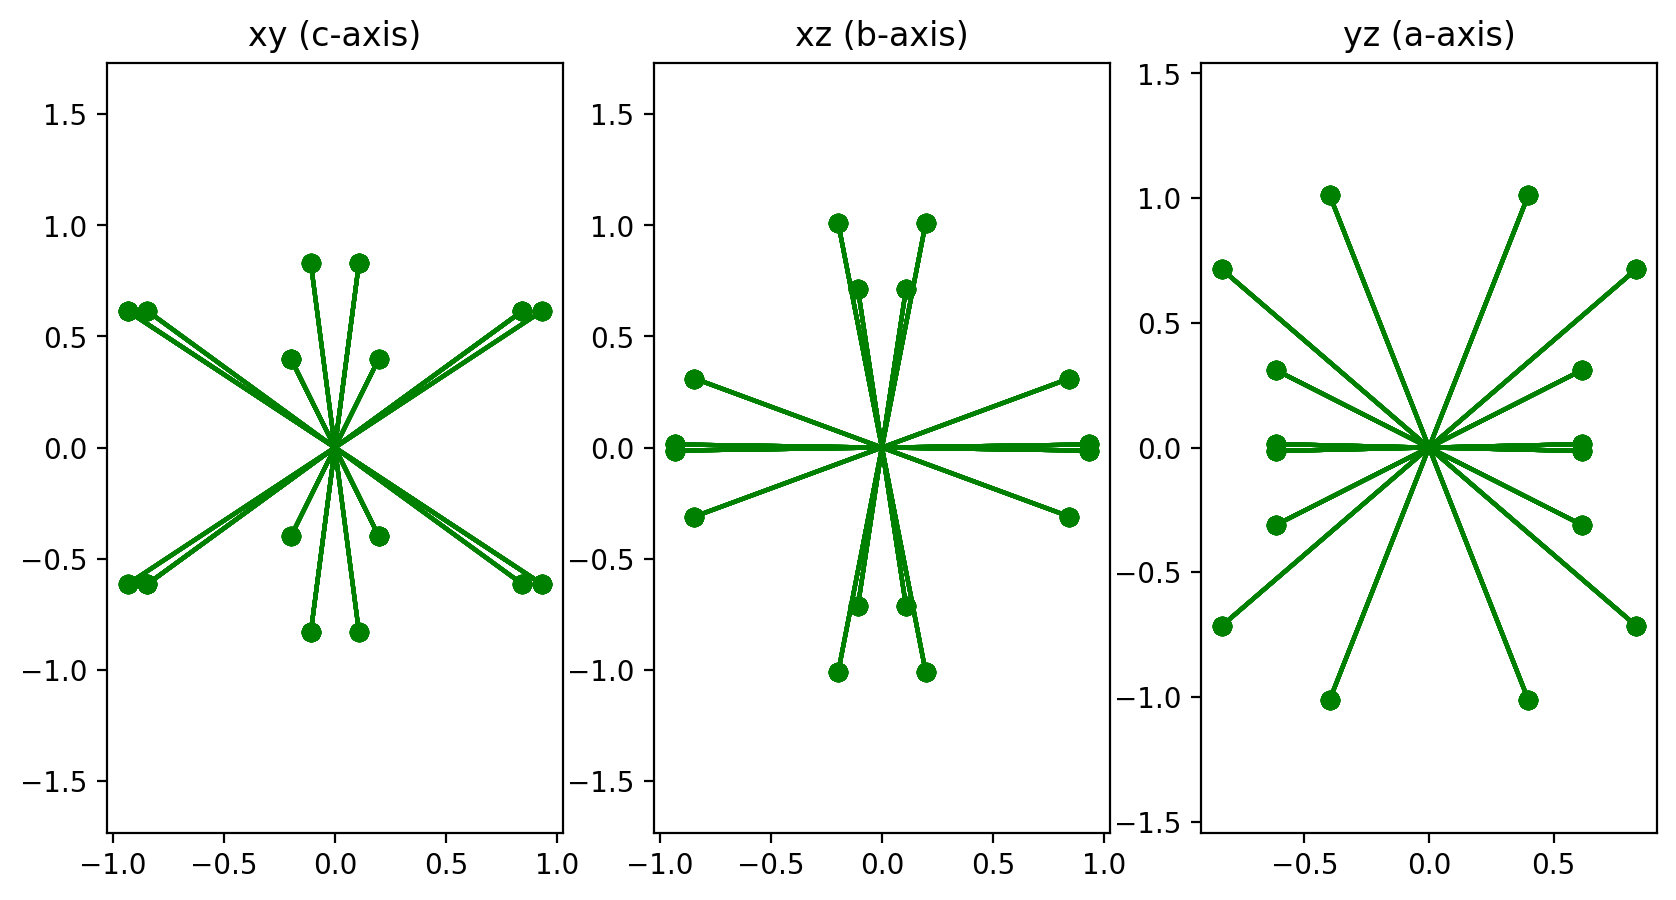

In [513]:
faces = {}
for site_idx, surroundings in enumerate(neighbors):
    site = surroundings['center']
    neighborhood = surroundings['neighborhood']
    drs = []
    done = []
    site_coords = site.coords
    for idx_0 in range(len(surroundings['neighborhood'])):
        site_0 = neighborhood[idx_0]
        r0 = site_0.coords
        if np.sqrt(np.sum((site_coords-r0)**2)) > 1.93:
            continue
        for idx_1 in range(len(surroundings['neighborhood'])):
            site_1 = neighborhood[idx_1]
            r1 = site_1.coords
            for idx_2 in range(len(surroundings['neighborhood'])):
                sorted_indices = sorted([idx_0, idx_1, idx_2])
                if sorted_indices in done:
                    continue
                done.append(sorted_indices)
                site_2 = neighborhood[idx_2]
                r2 = site_2.coords
                dr01 = r0-r1
                dr02 = r0-r2
                dr12 = r1-r2
                dr01 = np.sqrt(np.sum(dr01**2))
                dr02 = np.sqrt(np.sum(dr02**2))
                dr12 = np.sqrt(np.sum(dr12**2))
                # print(dr01, end=',')
                if all(list(map(lambda x: x < 2.75 and x > 2.65, [dr01, dr02, dr12]))):
                    if site_idx not in faces:
                        faces[site_idx] = []
                    bary = (site_0.coords + site_1.coords + site_2.coords)/3
                    faces[site_idx].append([site_0, site_1, site_2, bary])
opposite = []
for site_idx, faces in faces.items():
    site = neighbors[site_idx]['center']
    for idx_0 in range(len(faces)):
        bary_0 = faces[idx_0][3]
        for idx_1 in range(idx_0, len(faces)):
            bary_1 = faces[idx_1][3]
            db01 = bary_0 - bary_1
            midp = (bary_0 + bary_1)/2
            if np.sqrt(np.sum((midp-site.coords)**2)) < 0.01:
                opposite.append(db01)

fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(10,5))
for oppo in opposite:
    xyproj = np.array([oppo[0],oppo[1]])
    xzproj = np.array([oppo[0],oppo[2]])
    yzproj = np.array([oppo[1],oppo[2]])
    ax[0].plot([-xyproj[0]/2,xyproj[0]/2],[-xyproj[1]/2,xyproj[1]/2],'go-')
    ax[1].plot([-xzproj[0]/2,xzproj[0]/2],[-xzproj[1]/2,xzproj[1]/2],'go-')
    ax[2].plot([-yzproj[0]/2,yzproj[0]/2],[-yzproj[1]/2,yzproj[1]/2],'go-')
    for axis, axis_name in zip(ax,['xy (c-axis)','xz (b-axis)','yz (a-axis)']):
        axis.axis('equal')
        axis.set_title(axis_name)
plt.show()

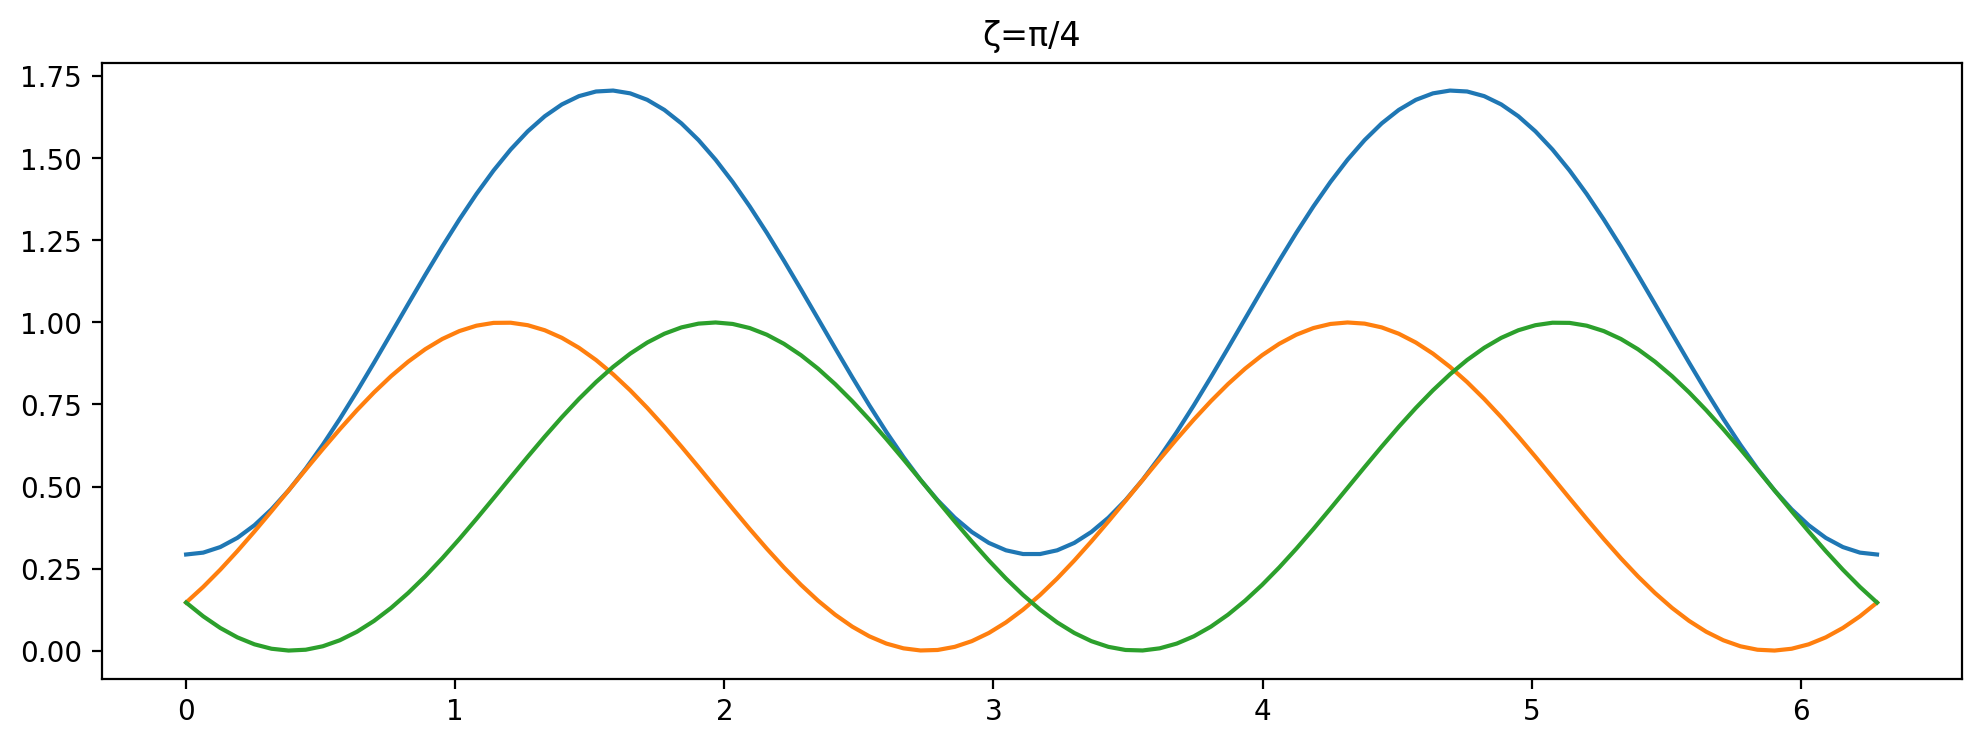

In [520]:
θs = np.linspace(0,2*np.pi,100)
ζ = np.pi/4
fig, ax = plt.subplots(figsize=(12,4))
ax.plot(θs, np.sin(θs+ζ/2)**2 + np.sin(θs-ζ/2)**2)
ax.plot(θs, np.sin(θs+ζ/2)**2)
ax.plot(θs, np.sin(θs-ζ/2)**2)
ax.set_title('ζ=π/4')
plt.show()

In [515]:
np.sqrt(np.sum((site.coords - r0)**2))

1.9104743593411557